/opt/anaconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training Prophet model for Crude Oil Brent Price...


01:35:06 - cmdstanpy - INFO - Chain [1] start processing
01:35:08 - cmdstanpy - INFO - Chain [1] done processing



Crude Oil Brent Price Metrics:
MAE: 102.08
RMSE: 114.14
MAPE: 137.07%


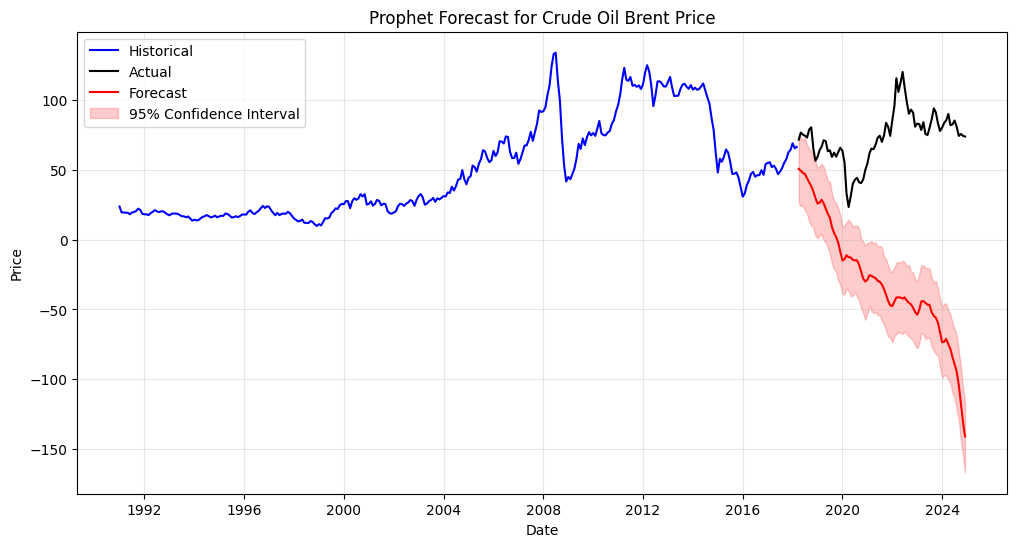

01:35:08 - cmdstanpy - INFO - Chain [1] start processing
01:35:08 - cmdstanpy - INFO - Chain [1] done processing



Training Prophet model for Cocoa Price...

Cocoa Price Metrics:
MAE: 2.15
RMSE: 3.38
MAPE: 52.04%


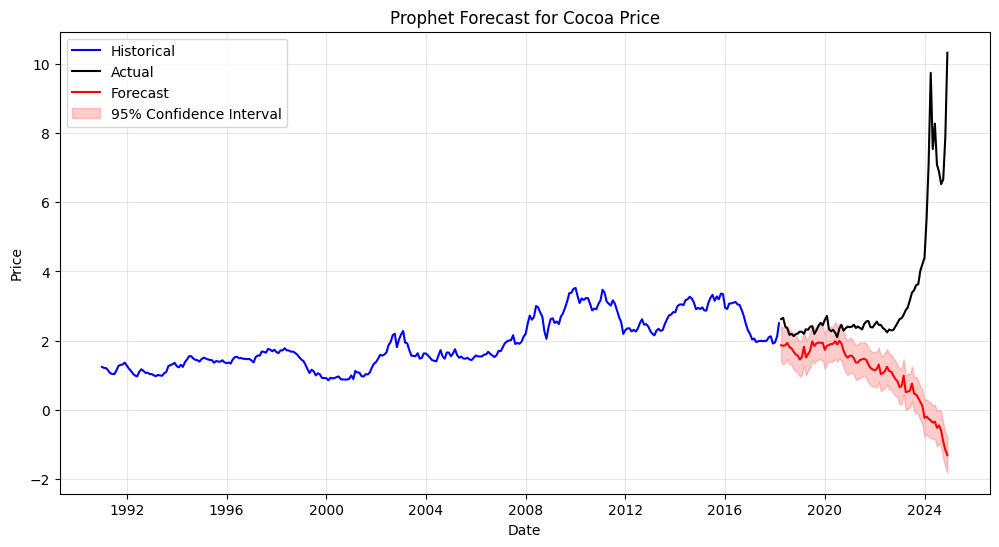

01:35:08 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for Gold Price...


01:35:08 - cmdstanpy - INFO - Chain [1] done processing



Gold Price Metrics:
MAE: 678.03
RMSE: 780.03
MAPE: 35.12%


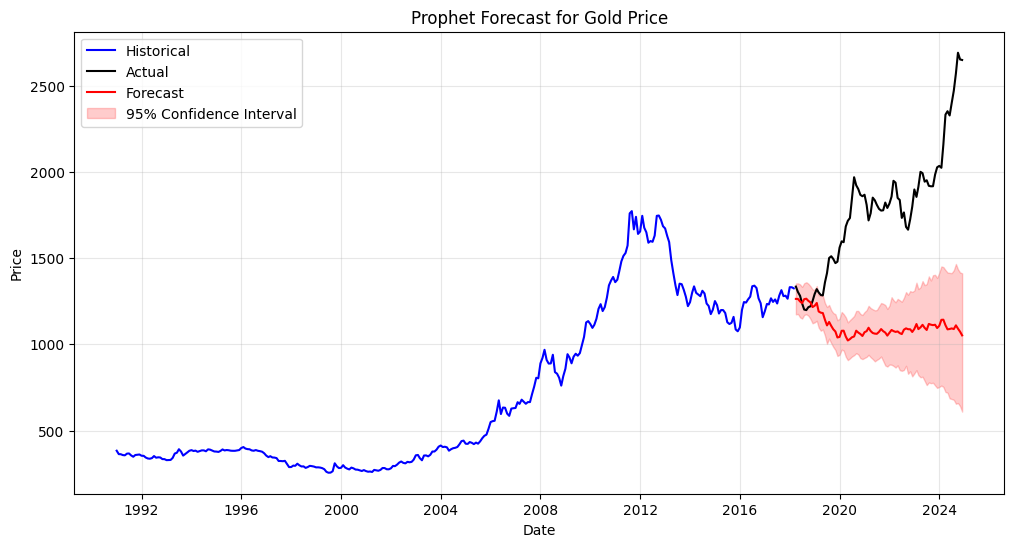


===== OVERALL METRICS SUMMARY =====

MAE:
  Crude Oil Brent Price: 102.08
  Cocoa Price: 2.15
  Gold Price: 678.03

RMSE:
  Crude Oil Brent Price: 114.14
  Cocoa Price: 3.38
  Gold Price: 780.03

MAPE:
  Crude Oil Brent Price: 137.07%
  Cocoa Price: 52.04%
  Gold Price: 35.12%


/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_50922/1521154856.py:134: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_df = pd.DataFrame({'ds': pd.date_range(start=last_date, periods=future_periods+1, freq='M')[1:]})


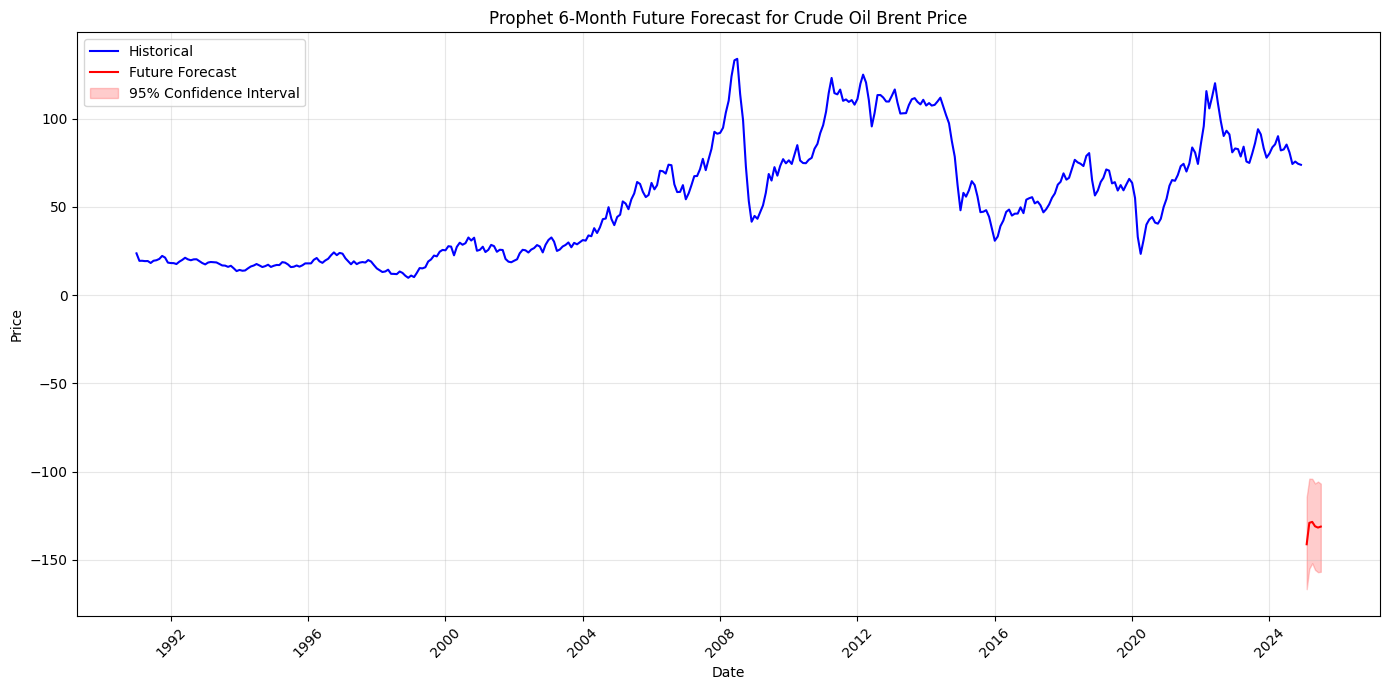


Future Forecast for Crude Oil Brent Price:
      Date    Forecast  Lower Bound  Upper Bound
2025-01-31 -141.197556  -166.671034  -114.338164
2025-02-28 -129.076939  -155.057076  -104.028554
2025-03-31 -128.528790  -151.980039  -104.111093
2025-04-30 -131.026227  -155.706334  -106.748091
2025-05-31 -131.742135  -157.034490  -105.689224
2025-06-30 -131.196818  -156.806231  -106.842084


/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_50922/1521154856.py:134: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_df = pd.DataFrame({'ds': pd.date_range(start=last_date, periods=future_periods+1, freq='M')[1:]})


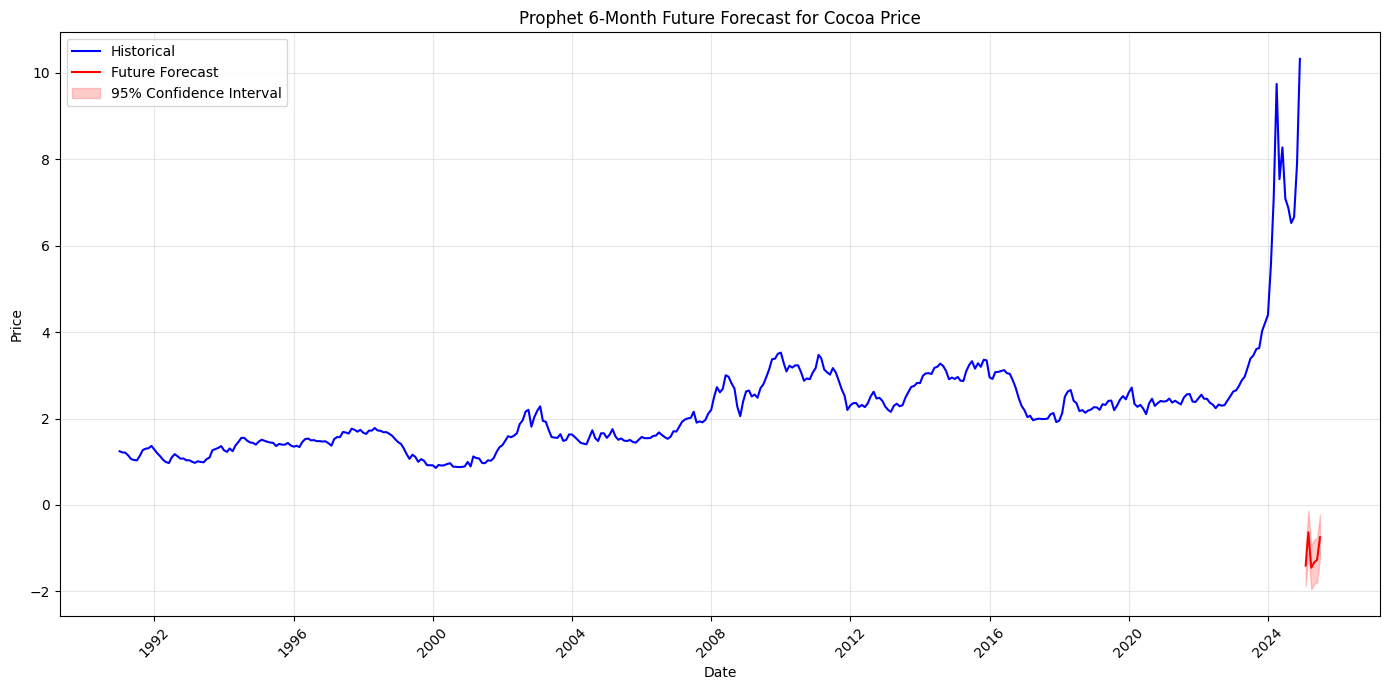


Future Forecast for Cocoa Price:
      Date  Forecast  Lower Bound  Upper Bound
2025-01-31 -1.400544    -1.887863    -0.918935
2025-02-28 -0.633684    -1.130789    -0.129382
2025-03-31 -1.450759    -1.947994    -0.932843
2025-04-30 -1.330509    -1.831655    -0.809105
2025-05-31 -1.266259    -1.789128    -0.762353
2025-06-30 -0.746649    -1.233423    -0.214307


/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_50922/1521154856.py:134: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_df = pd.DataFrame({'ds': pd.date_range(start=last_date, periods=future_periods+1, freq='M')[1:]})


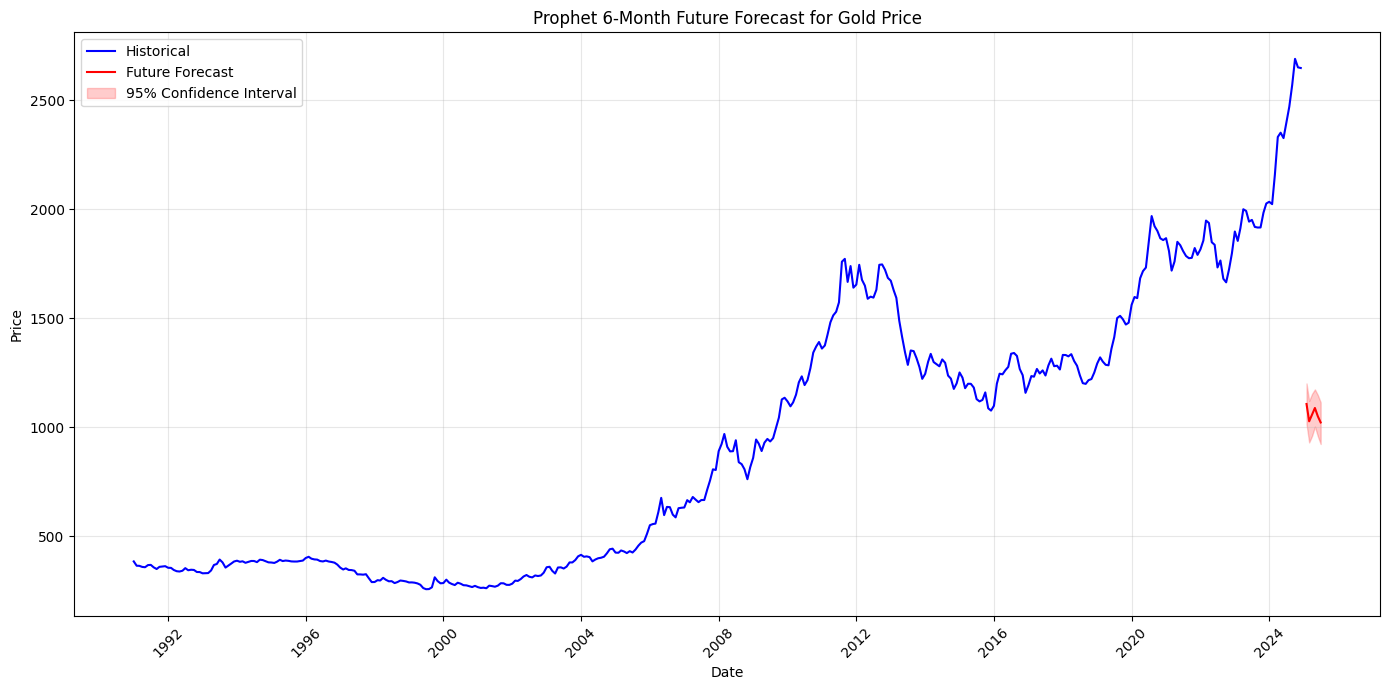


Future Forecast for Gold Price:
      Date    Forecast  Lower Bound  Upper Bound
2025-01-31 1106.057642  1013.720786  1200.301898
2025-02-28 1026.563516   929.598294  1120.080108
2025-03-31 1057.593499   960.027857  1152.759721
2025-04-30 1087.820859  1002.155095  1173.067819
2025-05-31 1049.598512   958.077890  1147.120050
2025-06-30 1021.343973   922.390054  1113.909067


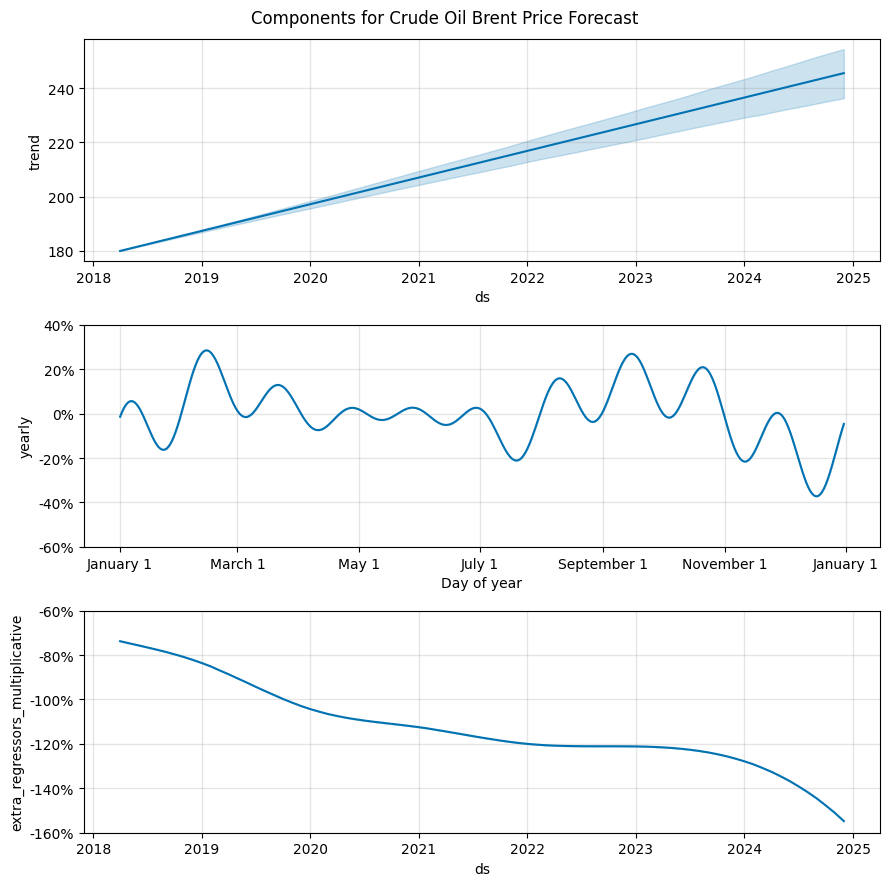

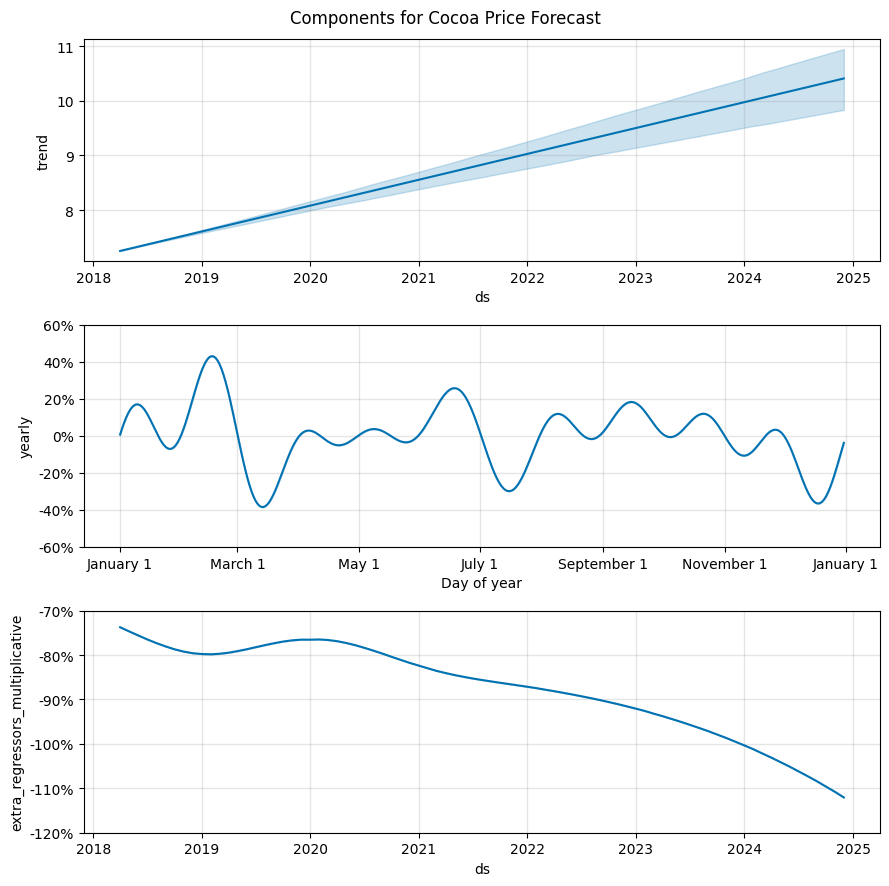

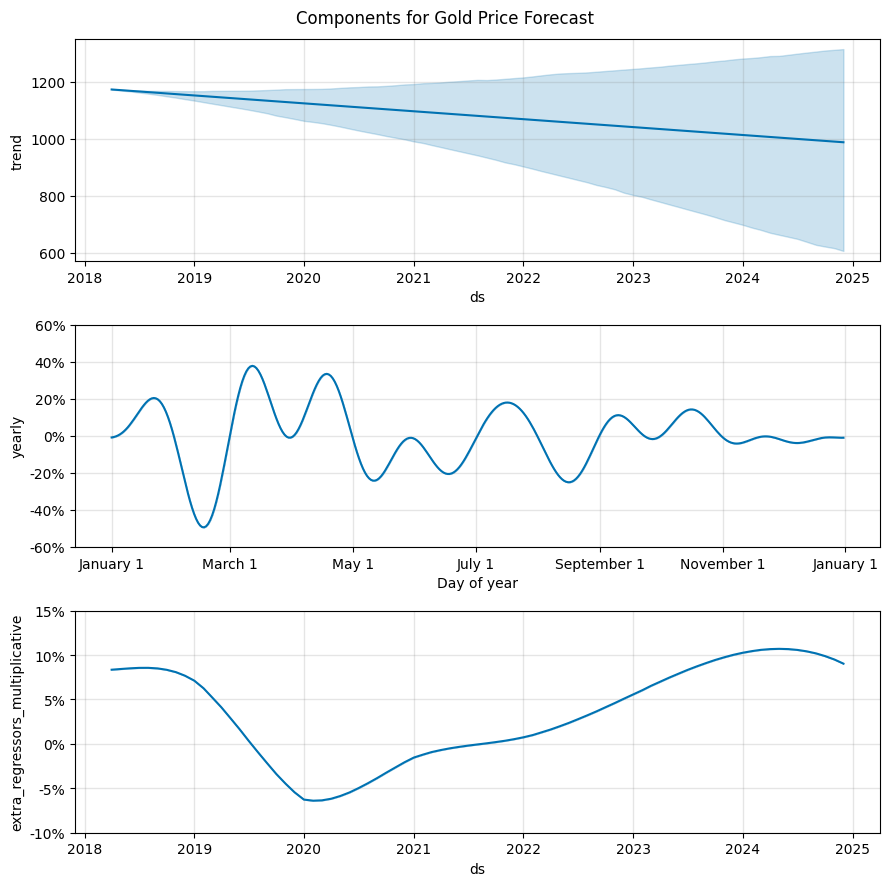

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df is your original DataFrame with the date index
# Reset index to make 'date' a column
df = pd.read_csv('merged_macro_commodity.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df_reset = df.reset_index()

# Create separate Prophet models for each commodity
commodity_cols = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']
feature_cols = ['Revenue, excluding grants (% of GDP)', 'GDP (constant 2015 US$)', 
                'Employment to population ratio (15+, total %)']

# Split data into train and test sets (using last 20% for testing)
test_size = int(0.2 * len(df_reset))
train_size = len(df_reset) - test_size

train_df = df_reset.iloc[:train_size]
test_df = df_reset.iloc[train_size:]

# Dictionary to store models, forecasts and metrics
prophet_models = {}
forecasts = {}
metrics = {'MAE': {}, 'RMSE': {}, 'MAPE': {}}

# Helper function to calculate MAPE
def calculate_mape(y_true, y_pred):
    """Calculate MAPE with handling for zero values"""
    mask = (y_true != 0)
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Function to evaluate forecasts
def evaluate_forecast(forecast, actual, commodity_name):
    # Merge forecast with actual values for evaluation
    forecast_vs_actual = forecast.merge(
        actual[['ds', 'y']], on='ds', how='inner', suffixes=('_pred', '')
    )
    
    # Calculate metrics
    mae = mean_absolute_error(forecast_vs_actual['y'], forecast_vs_actual['yhat'])
    rmse = np.sqrt(mean_squared_error(forecast_vs_actual['y'], forecast_vs_actual['yhat']))
    mape = calculate_mape(forecast_vs_actual['y'], forecast_vs_actual['yhat'])
    
    # Store metrics
    metrics['MAE'][commodity_name] = mae
    metrics['RMSE'][commodity_name] = rmse
    metrics['MAPE'][commodity_name] = mape
    
    # Print metrics
    print(f"\n{commodity_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return forecast_vs_actual

# Train Prophet models for each commodity
for commodity in commodity_cols:
    print(f"\nTraining Prophet model for {commodity}...")
    
    # Prepare data for Prophet (needs 'ds' for dates and 'y' for target)
    prophet_df = train_df[['date', commodity]].rename(columns={'date': 'ds', commodity: 'y'})
    
    # Add macroeconomic regressors
    for feature in feature_cols:
        prophet_df[feature] = train_df[feature].values
    
    # Initialize and train Prophet model
    model = Prophet(yearly_seasonality=True, 
                   weekly_seasonality=False,
                   daily_seasonality=False,
                   seasonality_mode='multiplicative',
                   interval_width=0.95)
    
    # Add regressors
    for feature in feature_cols:
        model.add_regressor(feature)
    
    # Fit model
    model.fit(prophet_df)
    prophet_models[commodity] = model
    
    # Create test data for Prophet with future regressor values
    future_df = test_df[['date'] + feature_cols].rename(columns={'date': 'ds'})
    
    # Make prediction
    forecast = model.predict(future_df)
    forecasts[commodity] = forecast
    
    # Evaluate predictions
    test_actual = test_df[['date', commodity]].rename(columns={'date': 'ds', commodity: 'y'})
    forecast_vs_actual = evaluate_forecast(forecast, test_actual, commodity)
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    
    # Plot historical data and forecast
    plt.plot(train_df['date'], train_df[commodity], 'b-', label='Historical')
    plt.plot(test_df['date'], test_df[commodity], 'k-', label='Actual')
    plt.plot(test_df['date'], forecast['yhat'], 'r-', label='Forecast')
    plt.fill_between(test_df['date'], 
                     forecast['yhat_lower'], 
                     forecast['yhat_upper'], 
                     color='r', 
                     alpha=0.2, 
                     label='95% Confidence Interval')
    
    plt.title(f'Prophet Forecast for {commodity}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'prophet_forecast_{commodity.replace(" ", "_")}.png')
    plt.show()

# Compare all commodities' metrics
print("\n===== OVERALL METRICS SUMMARY =====")
for metric_name in metrics:
    print(f"\n{metric_name}:")
    for commodity, value in metrics[metric_name].items():
        print(f"  {commodity}: {value:.2f}" + ("%" if metric_name == 'MAPE' else ""))

# Forecast into the future (6 months ahead)
for commodity in commodity_cols:
    # Get the last date in the dataset
    last_date = df_reset['date'].max()
    
    # Create future dataframe for 6 months
    future_periods = 6
    future_df = pd.DataFrame({'ds': pd.date_range(start=last_date, periods=future_periods+1, freq='M')[1:]})
    
    # For regressors, we'll need values - here we use the last known values
    # In a real scenario, you might want to forecast these features first
    for feature in feature_cols:
        future_df[feature] = df_reset[feature].iloc[-1]
    
    # Make prediction
    future_forecast = prophet_models[commodity].predict(future_df)
    
    # Plot the forecast including historical + future
    plt.figure(figsize=(14, 7))
    
    # Plot all historical data
    plt.plot(df_reset['date'], df_reset[commodity], 'b-', label='Historical')
    
    # Plot future forecast
    plt.plot(future_forecast['ds'], future_forecast['yhat'], 'r-', label='Future Forecast')
    plt.fill_between(future_forecast['ds'], 
                     future_forecast['yhat_lower'], 
                     future_forecast['yhat_upper'], 
                     color='r', 
                     alpha=0.2, 
                     label='95% Confidence Interval')
    
    plt.title(f'Prophet 6-Month Future Forecast for {commodity}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'prophet_future_forecast_{commodity.replace(" ", "_")}.png')
    plt.show()
    
    # Print the forecasted values
    print(f"\nFuture Forecast for {commodity}:")
    forecast_table = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_table.columns = ['Date', 'Forecast', 'Lower Bound', 'Upper Bound']
    print(forecast_table.to_string(index=False))

# Component plots to understand the impact of each regressor
for commodity in commodity_cols:
    model = prophet_models[commodity]
    
    # Create a figure for the components plot
    fig = model.plot_components(forecasts[commodity])
    plt.suptitle(f'Components for {commodity} Forecast')
    plt.tight_layout()
    plt.savefig(f'prophet_components_{commodity.replace(" ", "_")}.png')
    plt.show()